In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import normaltest

%matplotlib notebook
pd.options.display.float_format = '{:,.2f}'.format
seed(42)

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, 
             gridlines='--', ticks=True, grid=False, figsize=(7, 5))

### Wholesale Data

In [3]:
data = pd.read_csv('wholesale_customers_data.csv') 
data.describe().append(data.nunique().to_frame('nunique').T)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.00,440.00,440.00,440.00,440.00,440.00,440.00,440.00
mean,1.32,2.54,"12,000.30","5,796.27","7,951.28","3,071.93","2,881.49","1,524.87"
std,0.47,0.77,"12,647.33","7,380.38","9,503.16","4,854.67","4,767.85","2,820.11"
min,1.00,1.00,3.00,55.00,3.00,25.00,3.00,3.00
25%,1.00,2.00,"3,127.75","1,533.00","2,153.00",742.25,256.75,408.25
50%,1.00,3.00,"8,504.00","3,627.00","4,755.50","1,526.00",816.50,965.50
75%,2.00,3.00,"16,933.75","7,190.25","10,655.75","3,554.25","3,922.00","1,820.25"
max,2.00,3.00,"112,151.00","73,498.00","92,780.00","60,869.00","40,827.00","47,943.00"
nunique,2.00,3.00,433.00,421.00,430.00,426.00,417.00,403.00


### Drop Channel & Region

In [4]:
product_data = data.drop(['Channel', 'Region'], axis=1)
products = product_data.columns.tolist()

In [5]:
product_data.apply(normaltest).apply(pd.Series, index=['stat', 'p'])

,stat,p
Fresh,274.34,0.00
Milk,410.65,0.00
Grocery,374.02,0.00
Frozen,546.90,0.00
Detergents_Paper,371.82,0.00
Delicatessen,793.30,0.00


### Check for Outliers 

<IPython.core.display.Javascript object>


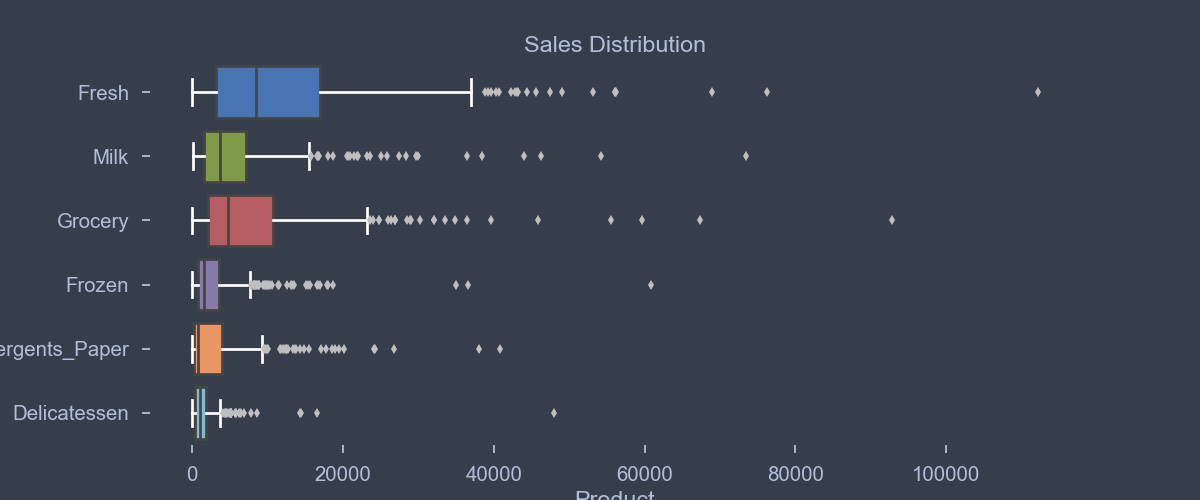

In [6]:
ax = plt.figure(figsize=(12, 5)).gca(title='Sales Distribution', 
                                     xlabel='Product', ylabel='Sales (USD)')
flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none')
whiskerprops = capprops = dict(c='white')
sns.boxplot(data=product_data, orient='horizontal', 
    flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops);

### Apply natural log to transform long tails

In [7]:
log_product_data = np.log(product_data)

<IPython.core.display.Javascript object>


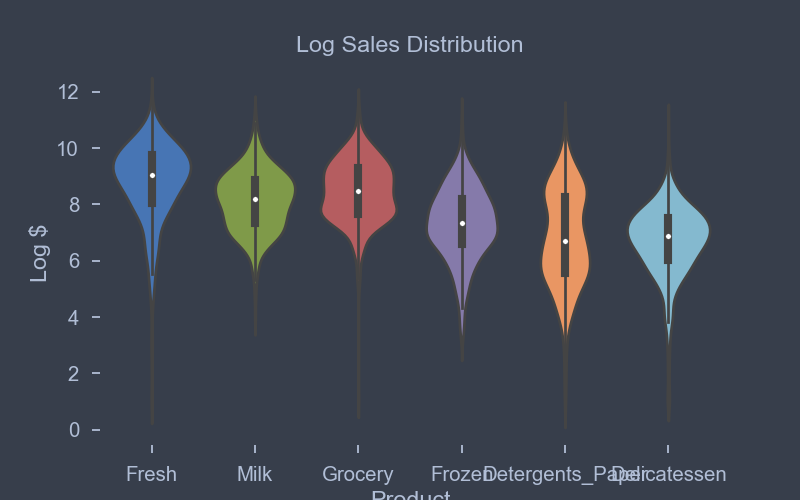

/home/stefan/.virtualenvs/unsupervised_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [8]:
ax = plt.figure(figsize=(8, 5)).gca(title='Log Sales Distribution', 
                                    xlabel='Product', ylabel='Log $')
sns.violinplot(data=log_product_data);

### Remove Outliers 

/home/stefan/.virtualenvs/unsupervised_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


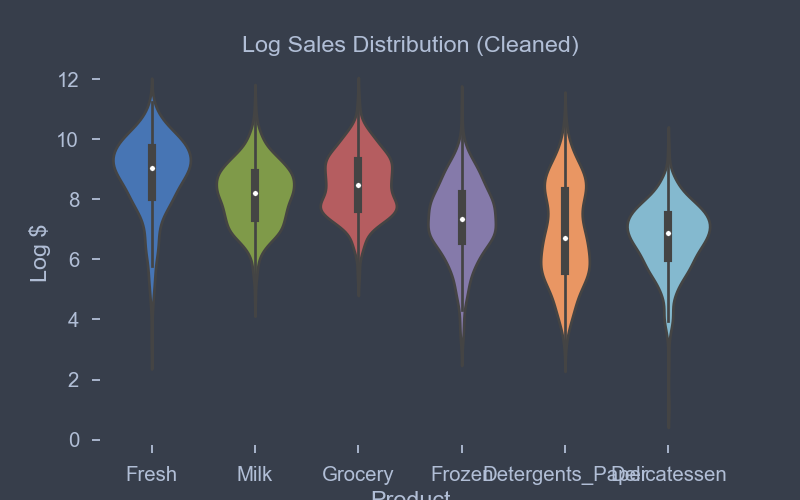

In [9]:
outliers = LocalOutlierFactor(n_neighbors=20, contamination=.05)
log_product_data['inlier'] = outliers.fit_predict(log_product_data)
log_product_data_clean = log_product_data.loc[
    log_product_data.inlier==1, products]

ax = plt.figure(figsize=(8, 5)).gca(
    title='Log Sales Distribution (Cleaned)', 
    xlabel='Product', ylabel='Log $')
sns.violinplot(data=log_product_data_clean);

In [10]:
log_product_data_clean.apply(normaltest).apply(pd.Series, index=['stat', 'p'])

,stat,p
Fresh,79.07,0.00
Milk,1.59,0.45
Grocery,3.05,0.22
Frozen,11.04,0.00
Detergents_Paper,55.90,0.00
Delicatessen,83.12,0.00


<IPython.core.display.Javascript object>


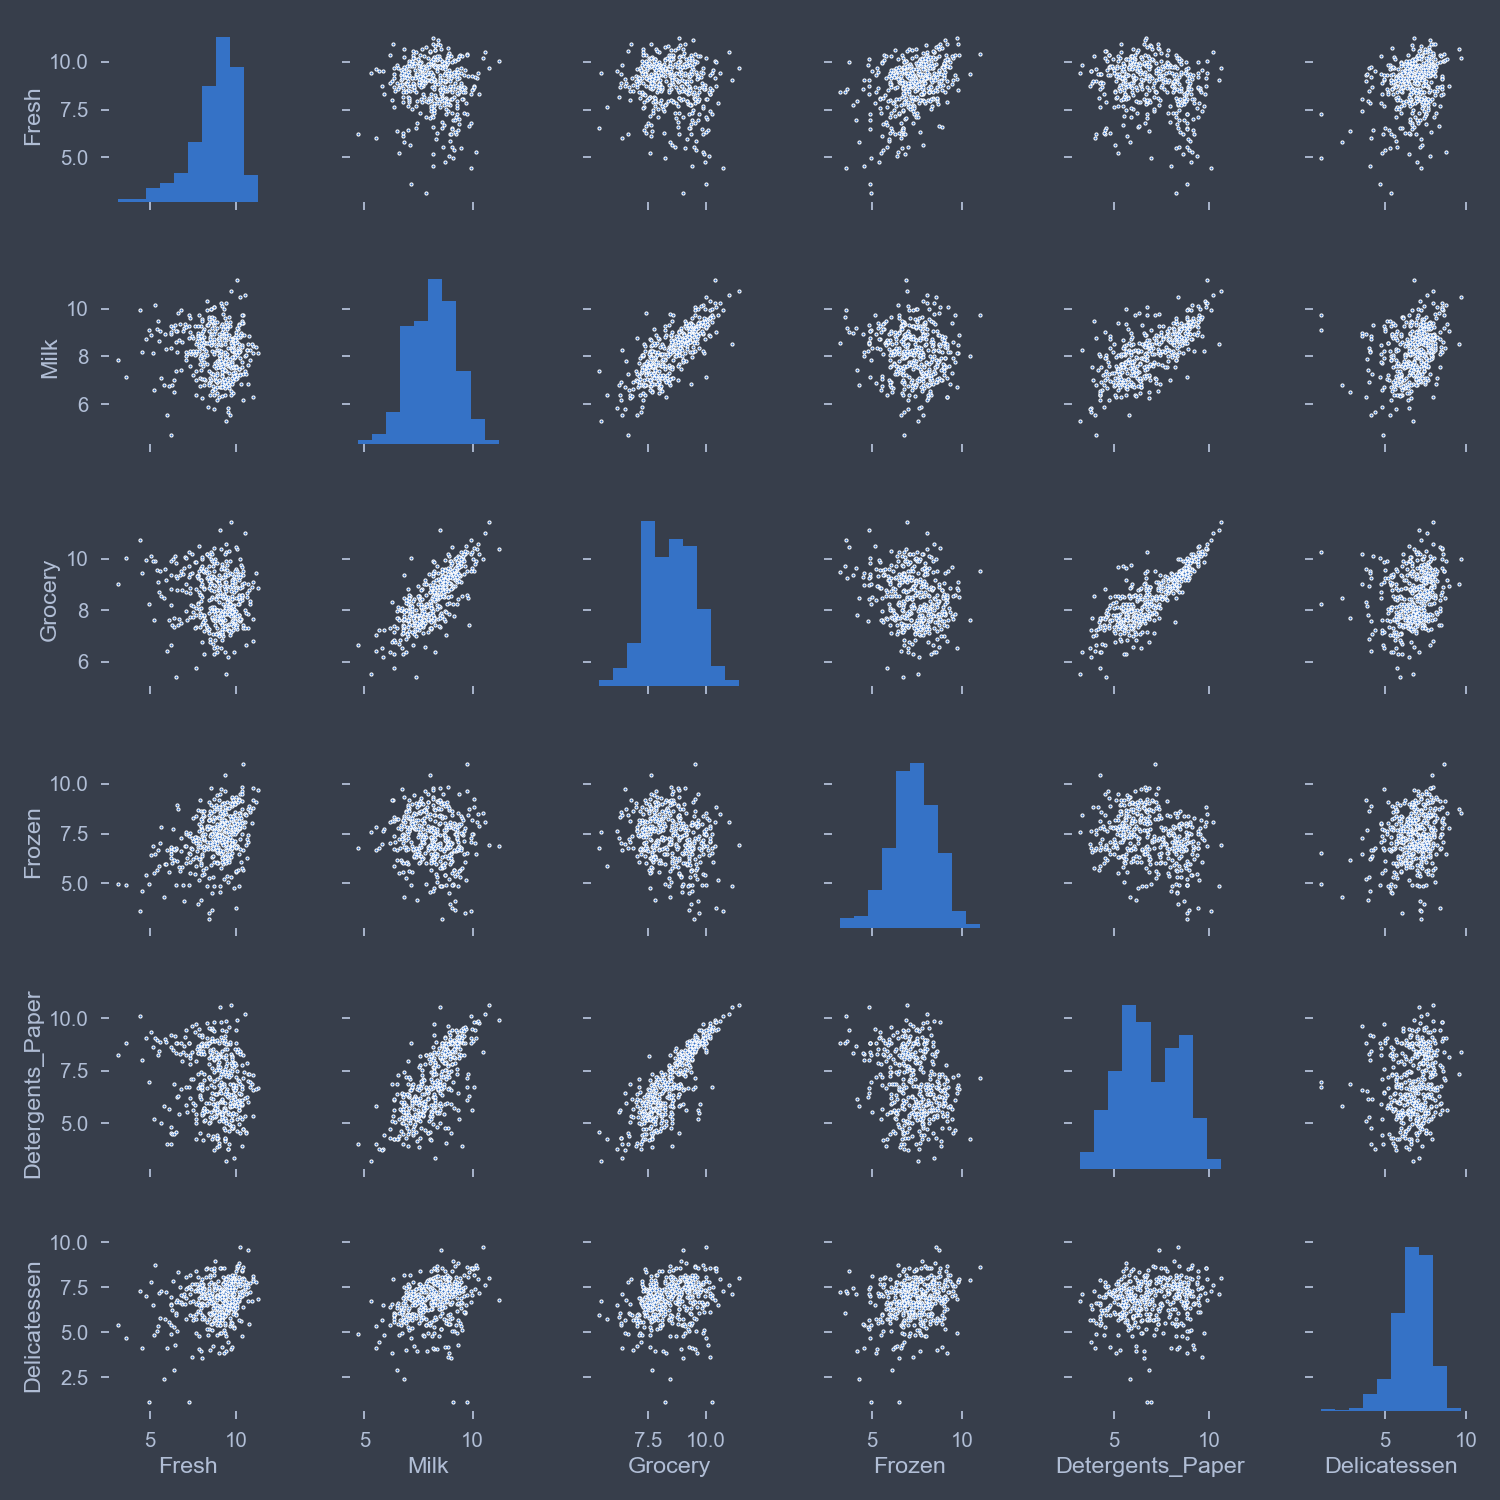

In [11]:
sns.pairplot(log_product_data_clean, plot_kws={'s': 5})
plt.tight_layout();

<IPython.core.display.Javascript object>


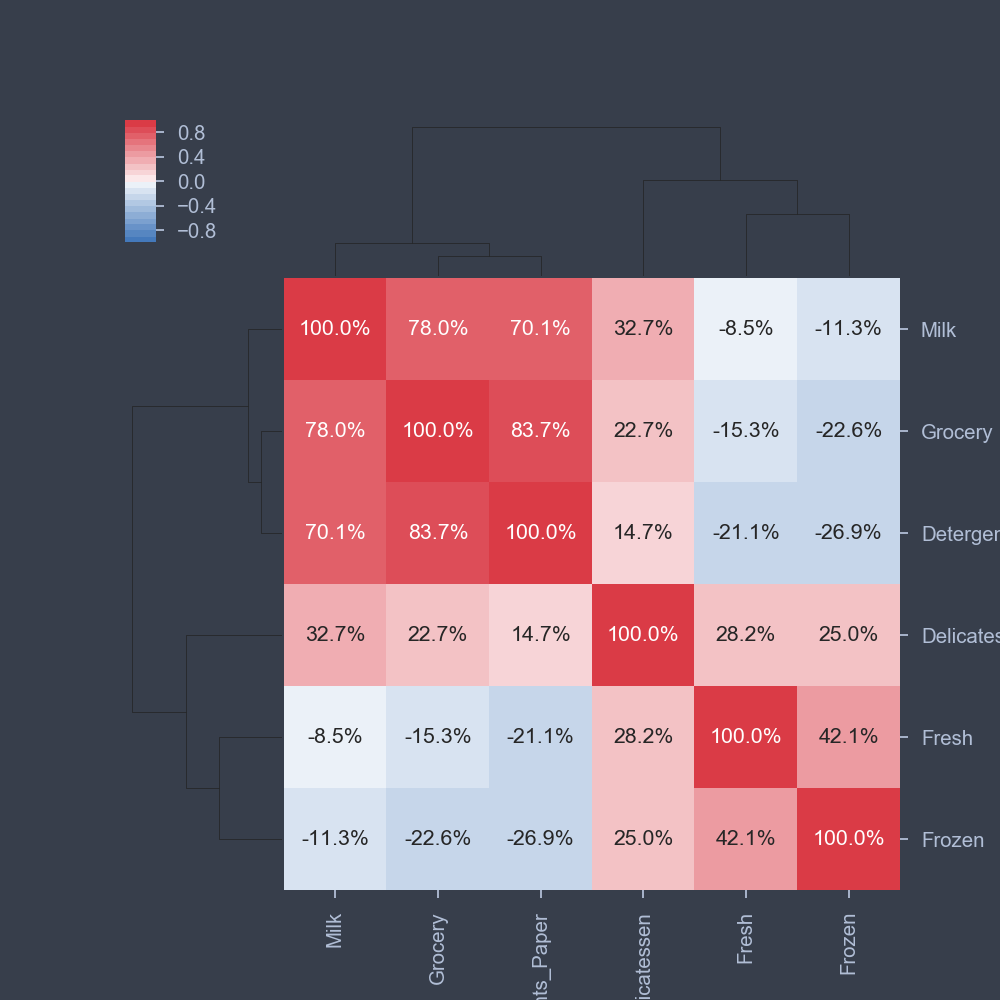

In [12]:
sns.clustermap(log_product_data_clean.corr(), 
               annot=True, fmt='.1%', center=0.0, 
               vmin=-1, vmax=1, cmap=sns.diverging_palette(250, 10, n=20));

### Biplot: Visualizing Product Relationships in 2D

In [13]:
pca = PCA(n_components=2)
x, y = pca.fit_transform(log_product_data_clean).T
exp_1, exp_2 = pca.explained_variance_ratio_
exp_1, exp_2

(0.46623390890043276, 0.27119914628229247)

In [14]:
pca.components_.T

array([[-0.22848966, -0.61736306],
       [ 0.39273282, -0.20508473],
       [ 0.44310622, -0.13180956],
       [-0.2557067 , -0.52456671],
       [ 0.72332331, -0.12170461],
       [ 0.09288569, -0.51908295]])

<IPython.core.display.Javascript object>


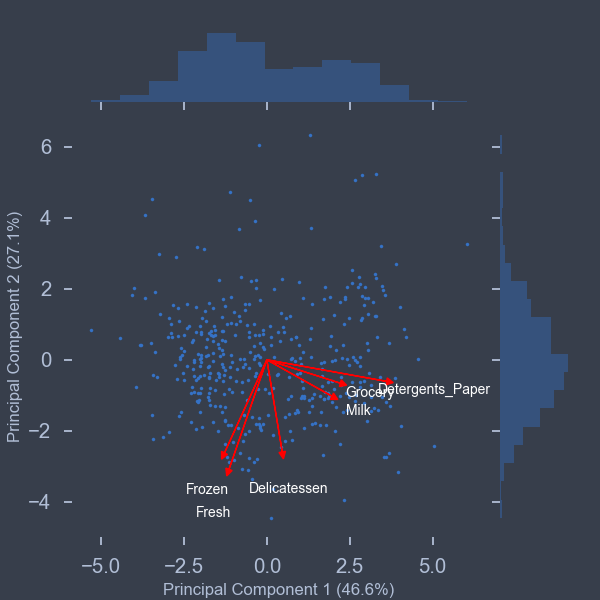

/home/stefan/.virtualenvs/unsupervised_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [15]:
ax = sns.jointplot(x=x, y=y, stat_func=None, 
                   joint_kws={'s':5}).ax_joint
ax.set_xlabel('Principal Component 1 ({:.1%})'.format(exp_1), fontsize=12)
ax.set_ylabel('Principal Component 2 ({:.1%})'.format(exp_2), fontsize=12)

arrow_size, text_pos = 5, 7
for i, component in enumerate(pca.components_.T):
    ax.arrow(0, 0, arrow_size * component[0], arrow_size * component[1],
             head_width=0.2, head_length=0.2, linewidth=1, color='red')
    ax.text(component[0] * text_pos, component[1] * text_pos, products[i], 
            color='white', ha='center', va='center', fontsize=10);

### Exploring the new Descriptors of the Wholesale Data

<IPython.core.display.Javascript object>


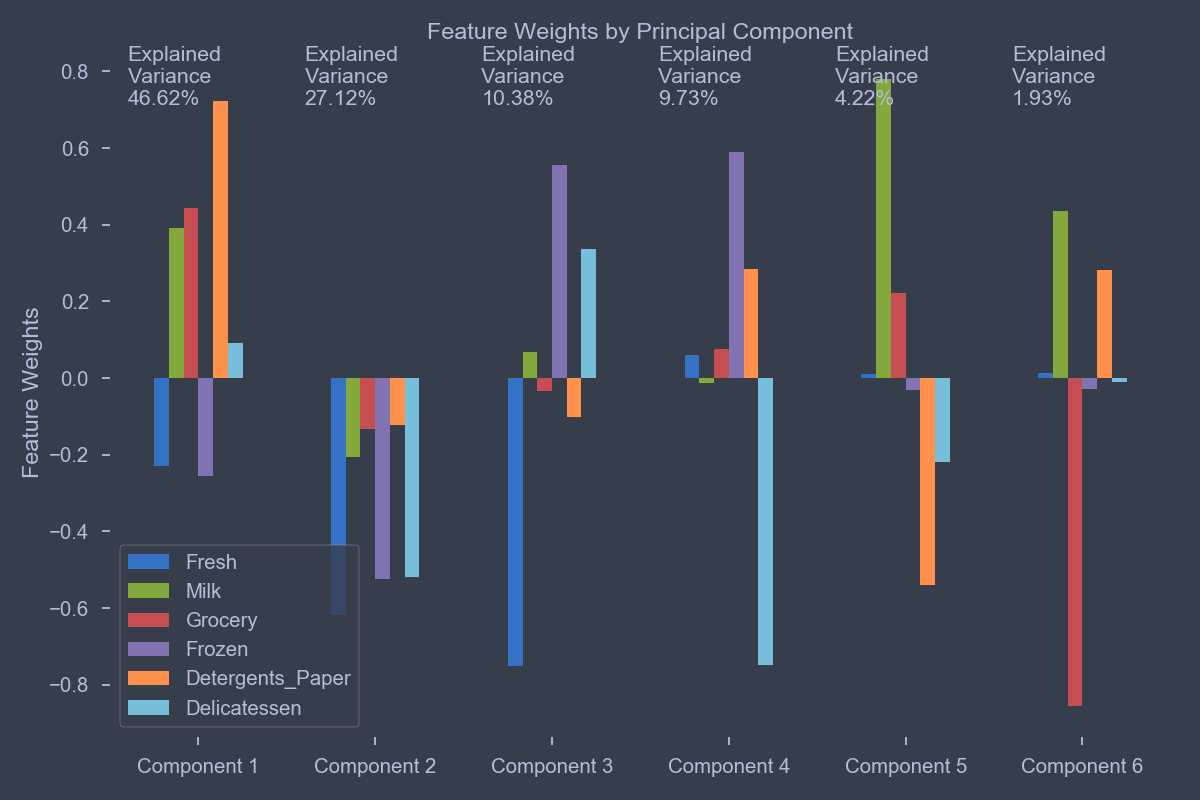

In [16]:
pca = PCA()
transformed = pca.fit_transform(log_product_data_clean)
components = pd.DataFrame(pca.components_, columns=products, 
                    index=['Component {}'.format(i) for i in range(1, 7)])
ax = components.plot.bar(figsize=(12, 8), rot=0, 
                         title='Feature Weights by Principal Component')
ax.set_ylabel('Feature Weights')
for i, exp_var in enumerate(pca.explained_variance_ratio_):
    ax.text(i-.4, ax.get_ylim()[1] - .15, 
            'Explained\nVariance\n{:.2%}'.format(exp_var))
plt.legend(loc=3)
plt.tight_layout();